In [30]:
import os
os.environ["OMP_NUM_THREADS"] = "1"


# Customer Segmentation with Clustering (Kaggle Mall Customers)

**Dataset:** **Kaggle Mall Customers** CSV (`mall_customers.csv`).  


### What you'll learn
- Types of clustering (K-Means, Agglomerative)
- How to choose **k** using **Elbow** and **Silhouette**
- How to **profile clusters** into actionable personas


https://www.kaggle.com/datasets/shwetabh123/mall-customers/data

*Prepared on: 2025-09-01*
*Prepared by: Maja M. Trajcheska*



## Load the dataset — What and why


In [3]:
import pandas as pd

data = pd.read_csv("./data/Mall_Customers.csv")
data

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [85]:
sample_data = data.head(10)
sample_data.to_csv("./data/Sample_Mall_Customers.csv")


## 1) Exploratory Data Analysis (EDA) 
**What:** Inspect summary stats to understand feature scales and possible outliers.  
**Look for:** Ranges, missing values, distribution hints.  
**Interpretation:** Guides preprocessing decisions (encoding, scaling).


In [4]:
data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [6]:
data.isna().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


## 2) Preprocessing — Encoding & Scaling
**What:** Convert `Gender` to numeric and scale features.  
**Look for:** Clean numeric matrix for distance-based clustering.  
**Interpretation:** After scaling, each feature contributes fairly to distance calculations.


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [42]:
# Encoding
X = data.copy()
le = LabelEncoder()
X["Gender"] = le.fit_transform(X["Gender"])

In [61]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[["Annual Income (k$)",	"Spending Score (1-100)"]])


## 3) K-Means 
**What:** Partition points into **k** clusters by minimizing within-cluster variance.  
**Look for:** Reasonable **k** that balances compactness and separation.  
**Interpretation:** Cluster centers represent typical customer profiles.


In [62]:
from sklearn.cluster import KMeans

In [63]:
km = KMeans(n_clusters=5, random_state=42)
km.fit(X_scaled)

C:\Users\mitre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=5, random_state=42)

In [64]:
labels = km.predict(X_scaled)

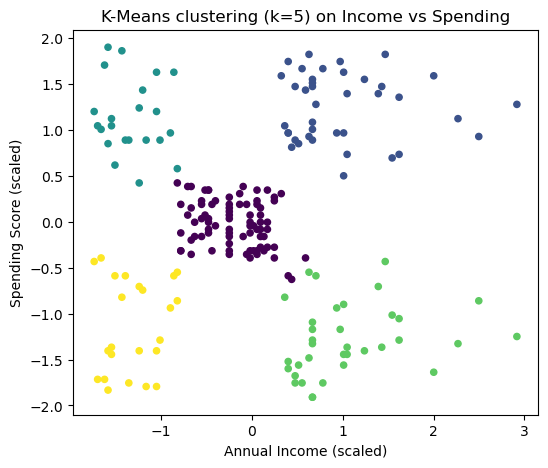

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=labels, s=20)
plt.title(f"K-Means clustering (k=5) on Income vs Spending")
plt.xlabel("Annual Income (scaled)")
plt.ylabel("Spending Score (scaled)")
plt.show()


### 3.1 Elbow Method 
**What:** Plot inertia vs k.  
**Look for:** The 'elbow' where adding clusters yields diminishing returns.  
**Interpretation:** Choose **k** near the elbow.


In [68]:
inertias = []

for k in range(2, 16):
    km = KMeans(n_clusters = k, random_state = 42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

inertias

C:\Users\mitre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\mitre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\mitre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\mitre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

[273.66888662642015,
 157.70400815035947,
 109.22822707921347,
 65.56840815571681,
 60.13287487193422,
 49.66824483736798,
 37.319122878338824,
 32.49508119910091,
 30.05932269404221,
 26.76120176636121,
 26.23289376978684,
 23.1935534219784,
 21.195257238649535,
 18.179104849335395]

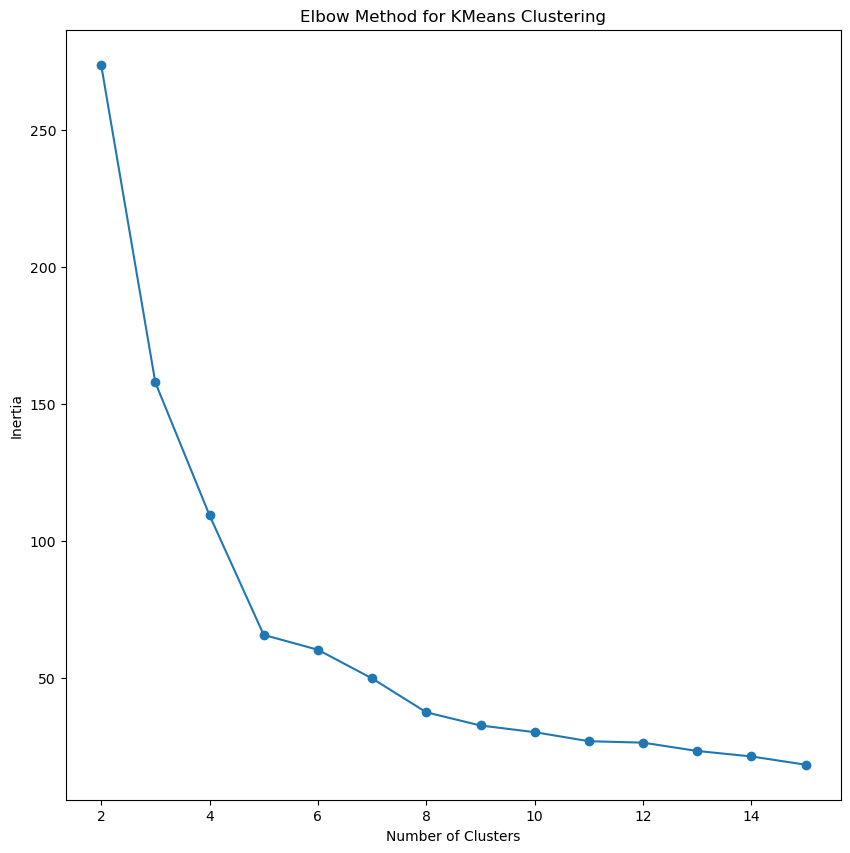

In [69]:
plt.figure(figsize=(10,10))
plt.plot(range(2, 16), inertias, marker='o')
plt.title("Elbow Method for KMeans Clustering")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()


### 3.2 Silhouette Analysis — How good are the clusters?
**What:** Compute a score in **[-1, 1]** (higher is better).  
**Look for:** Peak silhouette with sensible **k** value.  
**Interpretation:** >0.5 often indicates well-separated clusters.


In [70]:
from sklearn.metrics import silhouette_score

In [71]:
sil_scores = []

for k in range(2, 16):
    km = KMeans(n_clusters = k, random_state = 42)
    km.fit(X_scaled)
    labels = km.predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

sil_scores

C:\Users\mitre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\mitre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\mitre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\mitre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

[0.3973270007887498,
 0.46658474419000145,
 0.49434988482196784,
 0.5546571631111091,
 0.5138257534676561,
 0.50200146805547,
 0.4550112502601921,
 0.4566624374485964,
 0.44475993501732874,
 0.4456479428438176,
 0.3713686676601066,
 0.38264093256138937,
 0.3874613064238352,
 0.42716678409862796]

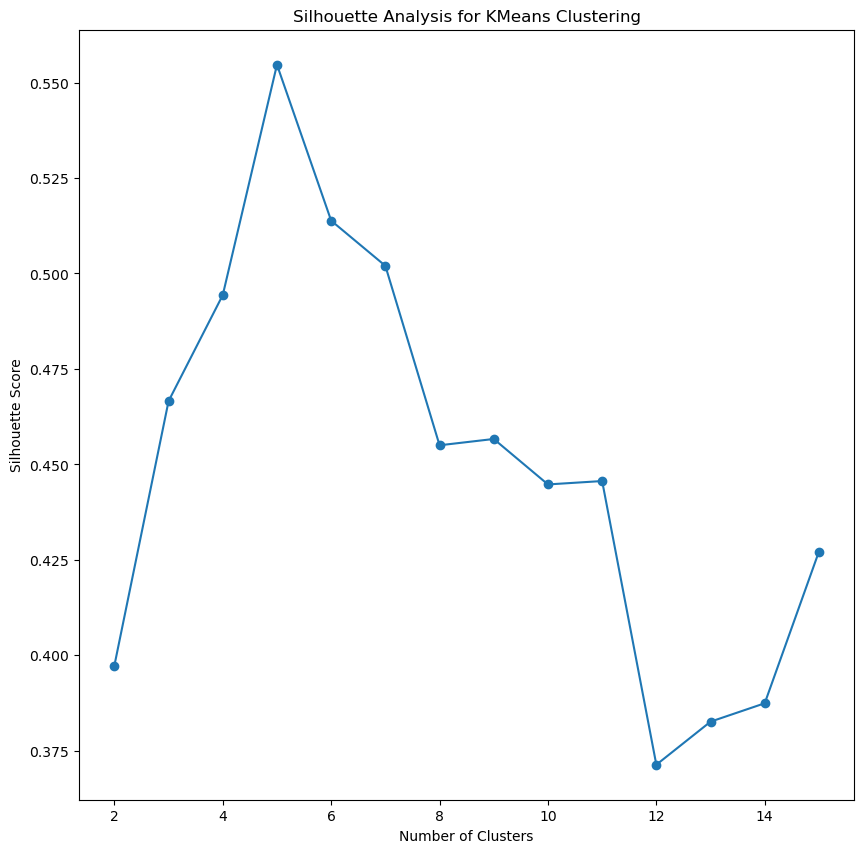

In [72]:
plt.figure(figsize=(10,10))
plt.plot(range(2, 16), sil_scores, marker='o')
plt.title("Silhouette Analysis for KMeans Clustering")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

In [73]:
import numpy as np

In [74]:
ks = range(2,16) # ks = [2,3,4,5, 6...15]
best_k = ks[int(np.argmax(sil_scores))]
best_k

5


### 3.3 Fit K-Means and Visualize (2D)
**What:** Fit K-Means with chosen **k** and visualize on two features.  
**Look for:** Clear separation aligned with personas (e.g., income vs spending).  
**Interpretation:** Identify clusters like *high income–high spenders*.


In [75]:
km = KMeans(n_clusters=best_k, random_state=42)
km.fit(X_scaled)

C:\Users\mitre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=5, random_state=42)

In [76]:
labels = km.predict(X_scaled)

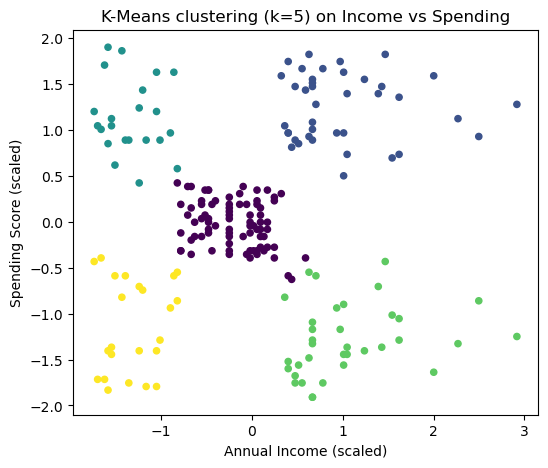

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=labels, s=20)
plt.title(f"K-Means clustering (k={best_k}) on Income vs Spending")
plt.xlabel("Annual Income (scaled)")
plt.ylabel("Spending Score (scaled)")
plt.show()


## 4) Agglomerative (Hierarchical) — What and interpretation
**What:** Merge the most similar points step-by-step to form clusters.  
**Look for:** Natural groupings without assuming spherical shapes.  
**Interpretation:** Compare silhouette with K-Means to judge cluster quality.


In [81]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters = best_k)
labels = agg.fit_predict(X_scaled)
labels

array([4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 2,
       4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 0, 1, 0, 1,
       2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 2, 1, 0, 1, 2, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1], dtype=int64)

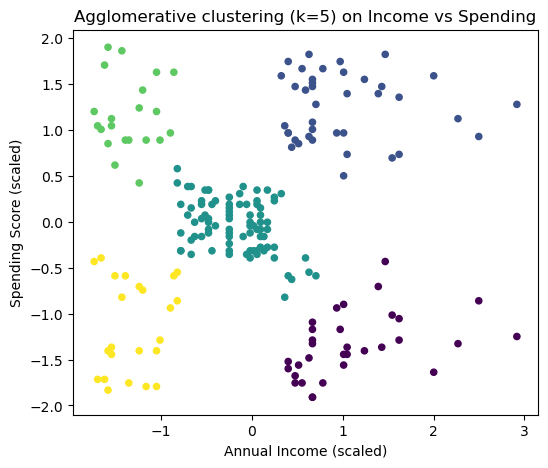

In [82]:
plt.figure(figsize=(6,5))
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=labels, s=20)
plt.title(f"Agglomerative clustering (k={best_k}) on Income vs Spending")
plt.xlabel("Annual Income (scaled)")
plt.ylabel("Spending Score (scaled)")
plt.show()


## 5) Cluster Profiling — What and interpretation
**What:** Summarize features per cluster to create personas.  
**Look for:** Meaningful differences in age, income, spending, gender.  
**Interpretation:** Link each cluster to actions (premium offers, loyalty perks, onboarding tips).


In [83]:
prof_df = data.copy()
prof_df["Cluster"] = labels

summary = prof_df.groupby("Cluster").agg({
    "Age": ["mean", "median"],
    "Annual Income (k$)": ["mean", "median"],
    "Spending Score (1-100)": ["mean", "median"],
    "Gender": lambda s: (s == "Female").mean()
}).rename(columns={"<lambda>": "female_share"})
summary

Age        Annual Income (k$)        Spending Score (1-100)  \
              mean median               mean median                   mean   
Cluster                                                                      
0        41.000000   41.5          89.406250   86.5              15.593750   
1        32.692308   32.0          86.538462   79.0              82.128205   
2        42.482353   46.0          55.811765   57.0              49.129412   
3        25.333333   23.0          25.095238   24.0              80.047619   
4        45.217391   46.0          26.304348   25.0              20.913043   

                     Gender  
        median female_share  
Cluster                      
0         15.0     0.437500  
1         83.0     0.538462  
2         49.0     0.600000  
3         77.0     0.571429  
4         17.0     0.608696